# Chest X-Ray Images for Pneumonia

## Table of Contents

    1. Introduction
    2. Importing Data
    3. Creating plotting functions 
    4. Setting up Training and Testing Data
    5. Sklearn Models
        5a. Linear Regression 
        5b. Decision Tree Classifier
        5c. Random Forest Classifier
        5d. XGB Classifier
    6. Keras Tensorflow Models
        6a. Convolutional Neural Network 1
        6b. Convolutional Neural Network 2
        6c. Hyperparameter Tuned Convolutional Neural Network
    7. Model Selection

### 1. Introduction

In this notebook, I will be creating models and evaluating their effectiveness on our data. First, I will use a PCA to create models using sklearn. Then, I will create 3 different convolutional neural networks using keras and tensorflow. The goal is to find the best model for predicting whether a patient has pneumonia based on a chest X-ray. 

### 2. Importing Data

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import HyperModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

<ipython-input-1-7d1a1f0ee84a>:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
categories = ['NORMAL', 'PNEUMONIA']
datasets = ['train', 'test']

In [3]:
## Importing the images

widths = []
heights = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + 
                             sets + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: ", round(images_size["widths"].mean(), 2))
print("Average image height: ", round(images_size["heights"].mean(), 2))

Average image width:  1327.83
Average image height:  970.6


In [92]:
## Saving image width and height for image size later

im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " , str(im_width))
print("image height: " , str(im_height))

image width:  132
image height:  97


### 3. Creating plotting functions 

In [5]:
## This function will plot the confusion matrix in a heat map for each tensorflow model

def plot_confusion(con_mat):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Model Accuracy')
    plt.show()

In [6]:
## This function will plot the images with their predicted labels and true labels for accurate predictions 
## for the tensorflow models. 

def plot_model_images_acc():
    
    cor = []
    for i in range(len(y_pred)):
        pred = categories[int(np.round(y_pred)[i][0])]
        actual = categories[y_test[i]]
        if pred == actual:
            cor.append(i)
    cor = cor[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Accurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        image = X_test[cor[j]]
        pred = categories[int(np.round(y_pred)[cor[j]][0])]
        actual = categories[y_test[cor[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [7]:
## This function will plot the images with their predicted labels and true labels for accurate predictions 
## for the sklearn models.

def plot_model_images_acc_pca():
    
    cor = []
    for i in range(len(y_pred)):
        pred = categories[y_pred[i]]
        actual = categories[y_test[i]]
        if pred == actual:
            cor.append(i)
    cor = cor[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Accurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        X_test_1 = X_test.reshape(1168, 97, 132, 1)
        image = X_test_1[cor[j]]
        pred = categories[y_pred[cor[j]]]
        actual = categories[y_test[cor[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [8]:
## This function will plot the images with their predicted labels and true labels for inaccurate predictions 
## for the tensorflow models.

def plot_model_images_inc():

    inc = []
    for i in range(len(y_pred)):
        pred = categories[int(np.round(y_pred)[i][0])]
        actual = categories[y_test[i]]
        if pred != actual:
            inc.append(i)
    inc = inc[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Inaccurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        image = X_test[inc[j]]
        pred = categories[int(np.round(y_pred)[inc[j]][0])]
        actual = categories[y_test[inc[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [9]:
## This function will plot the images with their predicted labels and true labels for inaccurate predictions 
## for the sklearn models.

def plot_model_images_inc_pca():
    
    inc = []
    for i in range(len(y_pred)):
        pred = categories[y_pred[i]]
        actual = categories[y_test[i]]
        if pred != actual:
            inc.append(i)
    inc = inc[0:9]
    
    fig = plt.gcf()
    plt.figure(figsize=(10, 8), dpi=80)
    plt.suptitle('Inaccurate Predictions', fontsize = 'xx-large')
    
    for j in range(0,9):
        plt.subplot(3, 3, j + 1)
        plt.axis('off') 
        X_test_1 = X_test.reshape(1168, 97, 132, 1)
        image = X_test_1[inc[j]]
        pred = categories[y_pred[inc[j]]]
        actual = categories[y_test[inc[j]]]
        plt.title("Predicted: " + pred + " /\n True value: " + actual)
        plt.imshow(image)
    plt.show()

In [10]:
## This function will plot the accuracy and loss history for the tensorflow models

plt.rcParams['figure.figsize'] = (12, 14)
def plot_accuracy_loss():
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')
    
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

### 4. Setting up Training and Testing Data

In [11]:
## Splitting the data into X and y

X = []
y = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + sets + '/' + cat + '/*.jpeg')
        y.extend([cat for _ in filelist])
        X.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])

X_array = np.stack(X, axis=0)

In [12]:
## Changing the categorical names to numeric labels

for n, i in enumerate(y):
    if i == 'NORMAL':
        y[n] = 0
    else:
        y[n] = 1

In [13]:
y_array = np.array(y)

In [14]:
## Creating the train/test split

X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, random_state=43, test_size=0.2, stratify = y)

In [15]:
X_train.shape

(4672, 97, 132)

In [16]:
X_test.shape

(1168, 97, 132)

In [17]:
y_train.shape

(4672,)

In [18]:
y_test.shape

(1168,)

In [19]:
## Normalizing the images

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

### 5a. Linear Regression 

In [20]:
pca = PCA()

In [21]:
X_train = X_train.reshape(4672, 12804)
X_test = X_test.reshape(1168, 12804)

In [22]:
X_train.shape

(4672, 12804)

In [23]:
## Using a PCA to condense features for the sklearn models

X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

In [25]:
model = LogisticRegression()

parameters = {'class_weight': ['balanced', None],
              'penalty' : ['l1', 'l2', 'none'],
              'C': np.arange(0.5, 20.0, 0.5),
              'fit_intercept': [True, False],
             'multi_class': ['auto','ovr','multinomial']}

In [26]:
## Hyperparameter Tuning the model

lg_random = RandomizedSearchCV(estimator = model, param_distributions = parameters,
                               verbose = False, n_iter = 10, cv = 5, random_state=42, n_jobs = -1)
lg_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", lg_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.85680702 0.84653162 0.85402306 0.8497427         nan        nan
 0.86429869 0.85530717 0.8497427         nan]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=2.0, class_weight='balanced', fit_intercept=False,
                   multi_class='ovr')


/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
y_pred = lg_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.92      0.82       315
           1       0.97      0.88      0.92       853

    accuracy                           0.89      1168
   macro avg       0.86      0.90      0.87      1168
weighted avg       0.91      0.89      0.90      1168



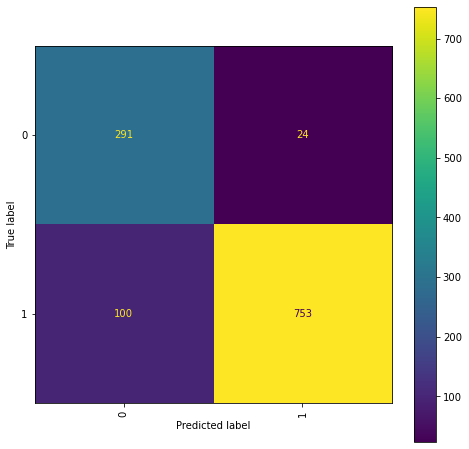

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(lg_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

<Figure size 864x1008 with 0 Axes>

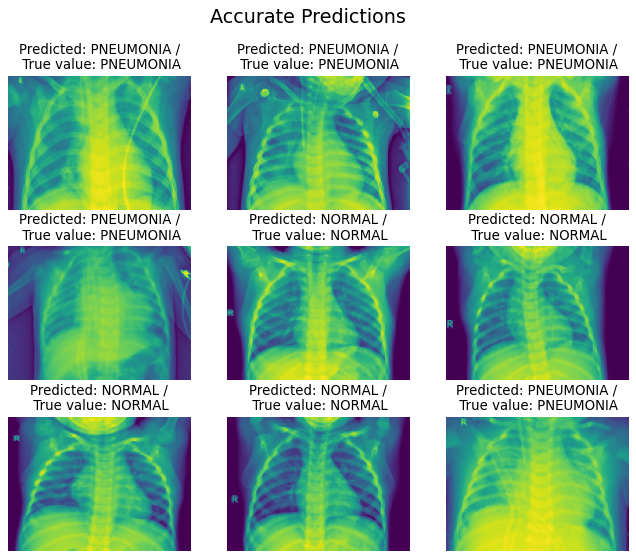

In [31]:
plot_model_images_acc_pca()

<Figure size 864x1008 with 0 Axes>

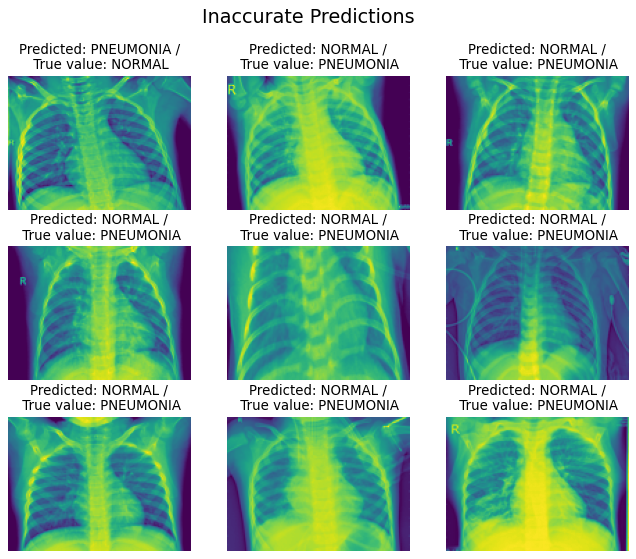

In [32]:
plot_model_images_inc_pca()

In [33]:
lg_acc_score = accuracy_score(y_test, y_pred)
lg_pre_score = precision_score(y_test, y_pred)
lg_rec_score = recall_score(y_test, y_pred)
lg_f1_score = f1_score(y_test, y_pred)

### 5b. Decision Tree Classifier

In [34]:
model = DecisionTreeClassifier()

parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_leaf_nodes': [3,4,5,10,15,20,25,50,75,100,125,150,200, None]}

In [35]:
## Hyperparameter Tuning the model

dt_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               random_state=42, n_jobs = -1)
dt_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", dt_random.best_estimator_)

 Results from Random Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(max_depth=75, max_features='auto', max_leaf_nodes=50,
                       min_samples_leaf=20, min_samples_split=650)


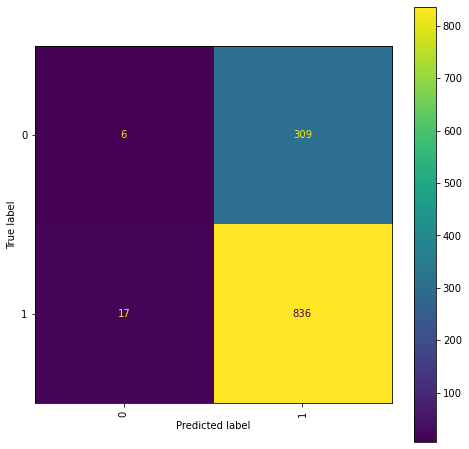

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(dt_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [37]:
y_pred = dt_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.26      0.02      0.04       315
           1       0.73      0.98      0.84       853

    accuracy                           0.72      1168
   macro avg       0.50      0.50      0.44      1168
weighted avg       0.60      0.72      0.62      1168



<Figure size 864x1008 with 0 Axes>

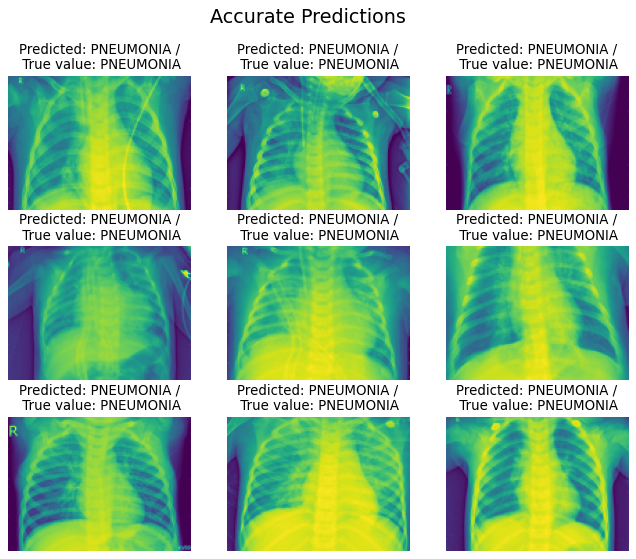

In [38]:
plot_model_images_acc_pca()

<Figure size 864x1008 with 0 Axes>

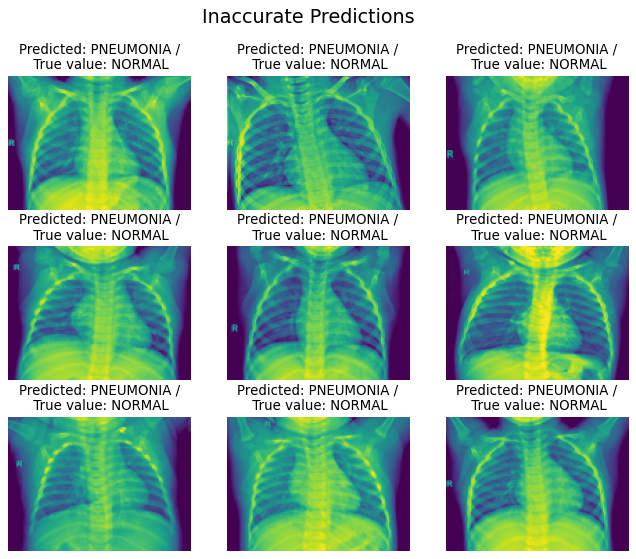

In [39]:
plot_model_images_inc_pca()

In [40]:
dt_acc_score = accuracy_score(y_test, y_pred)
dt_pre_score = precision_score(y_test, y_pred)
dt_rec_score = recall_score(y_test, y_pred)
dt_f1_score = f1_score(y_test, y_pred)

### 5c. Random Forest Classifier

In [41]:
model = RandomForestClassifier()

parameters = {'n_estimators': [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
              'criterion': ['gini', 'entropy'],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [3,4,5,10,15,20,25,50,75,100,125,150,200, None],
               'min_samples_split': [3,10,50,100,150,200,250,300,350,400,450,500,550,600,650,700],
               'min_samples_leaf': [1,2,3,4,5,10,20,25, 30, 50, 75, 100],
               'min_weight_fraction_leaf': [0.01, 0.1, 0.25, 0.001, 0.5, 0.75, 0.9],
               'bootstrap': [True, False]}

In [42]:
## Hyperparameter Tuning the model

rf_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
rf_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.75428002        nan        nan 0.76734029        nan
 0.73030815        nan        nan 0.73030815]
  warnings.warn(


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=False, max_depth=25, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=400,
                       min_weight_fraction_leaf=0.01, n_estimators=40)


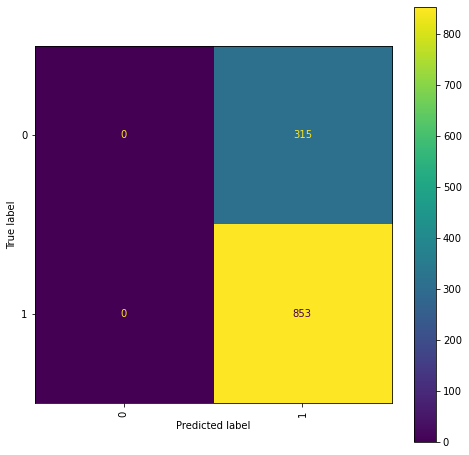

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rf_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [44]:
y_pred = rf_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       315
           1       0.73      1.00      0.84       853

    accuracy                           0.73      1168
   macro avg       0.37      0.50      0.42      1168
weighted avg       0.53      0.73      0.62      1168



/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

<Figure size 864x1008 with 0 Axes>

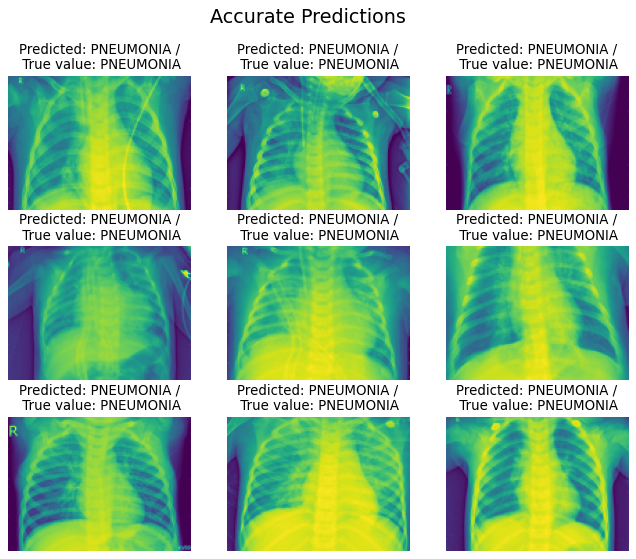

In [45]:
plot_model_images_acc_pca()

<Figure size 864x1008 with 0 Axes>

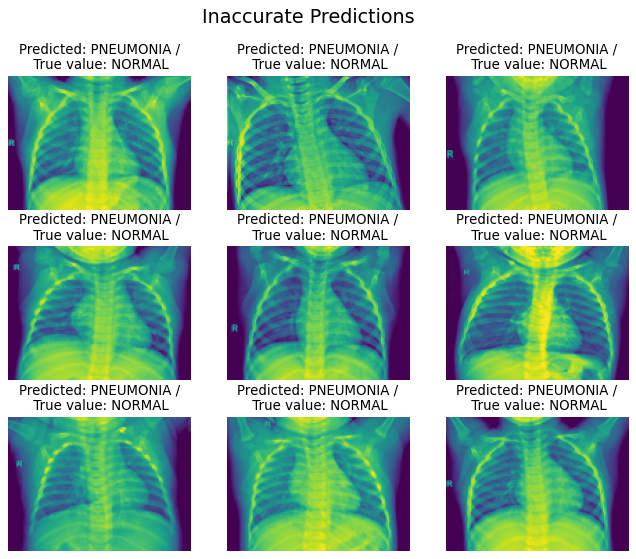

In [46]:
plot_model_images_inc_pca()

In [47]:
rf_acc_score = accuracy_score(y_test, y_pred)
rf_pre_score = precision_score(y_test, y_pred)
rf_rec_score = recall_score(y_test, y_pred)
rf_f1_score = f1_score(y_test, y_pred)

### 5d. XGB Classifier

In [48]:
model = XGBClassifier()

parameters = {'n_estimators':[5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.25, 0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'class_weight':[None,'balanced'],
          'max_depth': [1,2,3,4,5,10,15,20,25,50,75,100,125,150,200],
          'learning_rate':[0.001,0.01,0.05,0.1,0.2,0.3]
         }

In [49]:
## Hyperparameter Tuning the model

xgb_random = RandomizedSearchCV(estimator = model, param_distributions = parameters, n_iter = 10, cv = 5, 
                               verbose = False, random_state=42, n_jobs = -1)
xgb_random.fit(X_train_transformed, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", xgb_random.best_estimator_)

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 Results from Random Search 

 The best estimator across ALL searched params:
 XGBClassifier(base_score=0.5, booster='gbtree', class_weight=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              gamma=1.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=150, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)


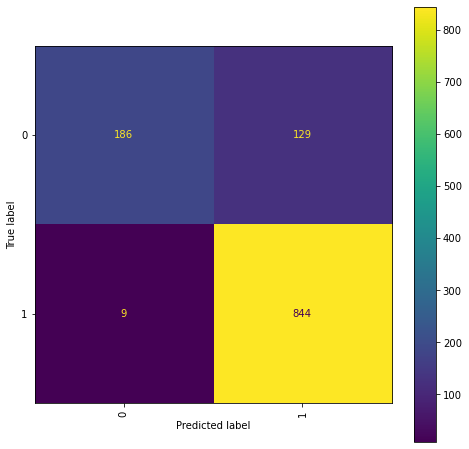

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgb_random, X_test_transformed, y_test, xticks_rotation='vertical', ax=ax)

In [51]:
y_pred = xgb_random.predict(X_test_transformed)
print('Classification report: \n', classification_report(y_test, y_pred))

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.59      0.73       315
           1       0.87      0.99      0.92       853

    accuracy                           0.88      1168
   macro avg       0.91      0.79      0.83      1168
weighted avg       0.89      0.88      0.87      1168



<Figure size 864x1008 with 0 Axes>

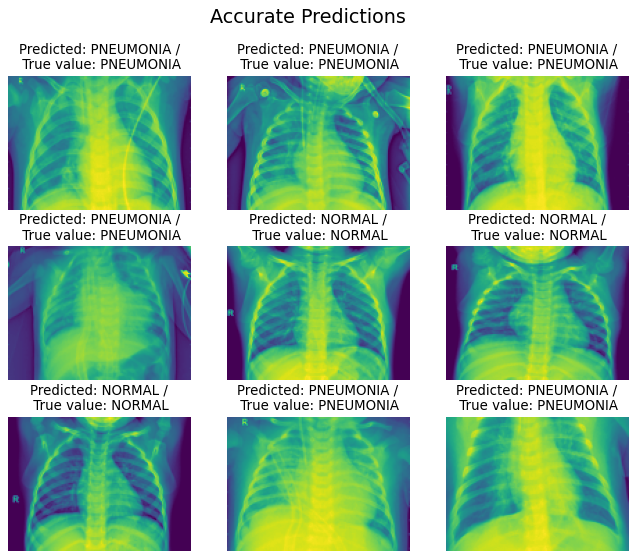

In [52]:
plot_model_images_acc_pca()

<Figure size 864x1008 with 0 Axes>

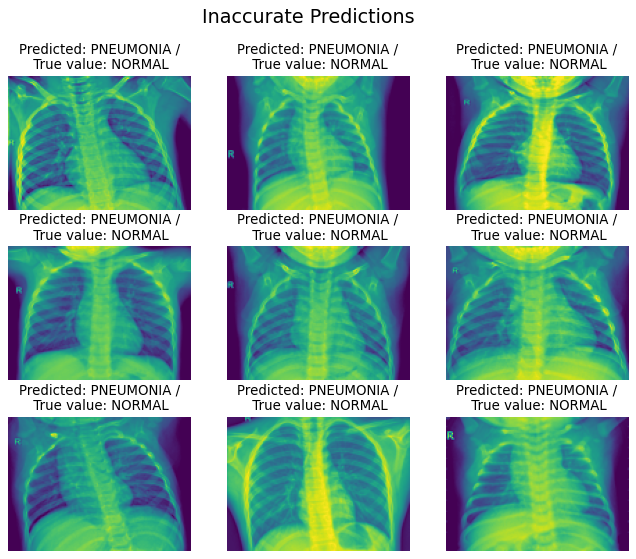

In [53]:
plot_model_images_inc_pca()

In [54]:
xgb_acc_score = accuracy_score(y_test, y_pred)
xgb_pre_score = precision_score(y_test, y_pred)
xgb_rec_score = recall_score(y_test, y_pred)
xgb_f1_score = f1_score(y_test, y_pred)

#### Sklearn did not produce great results. Now lets try to use Keras Tensorflow models.

### 6a. Convolutional Neural Network 1

In [55]:
batch_size = 32 

epochs = 25 

In [56]:
X_train = X_train.reshape(4672, 97, 132, 1)
X_test = X_test.reshape(1168, 97, 132, 1)

In [57]:
def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(im_height, im_width, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_1 = base_model()
cnn_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 132, 32)       320       
_________________________________________________________________
activation (Activation)      (None, 97, 132, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 32, 32)        0

In [58]:
## Training Model

es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_1.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/25
103/103 [==============================] - 42s 403ms/step - loss: 0.5036 - accuracy: 0.7700 - val_loss: 0.2682 - val_accuracy: 0.8916
Epoch 2/25
103/103 [==============================] - 41s 398ms/step - loss: 0.2278 - accuracy: 0.9080 - val_loss: 0.1765 - val_accuracy: 0.9372
Epoch 3/25
103/103 [==============================] - 41s 399ms/step - loss: 0.1655 - accuracy: 0.9385 - val_loss: 0.1662 - val_accuracy: 0.9280
Epoch 4/25
103/103 [==============================] - 41s 396ms/step - loss: 0.1492 - accuracy: 0.9462 - val_loss: 0.1584 - val_accuracy: 0.9401
Epoch 5/25
103/103 [==============================] - 40s 385ms/step - loss: 0.1416 - accuracy: 0.9468 - val_loss: 0.1531 - val_accuracy: 0.9358
Epoch 6/25
103/103 [==============================] - 40s 389ms/step - loss: 0.1227 - accuracy: 0.9590 - val_loss: 0.1481 - val_accuracy: 0.9387
Epoch 7/25
103/103 [==============================] - 40s 389ms/step - loss: 0.1211 - accuracy: 0.9554 - val_loss: 0.1402 - val_ac

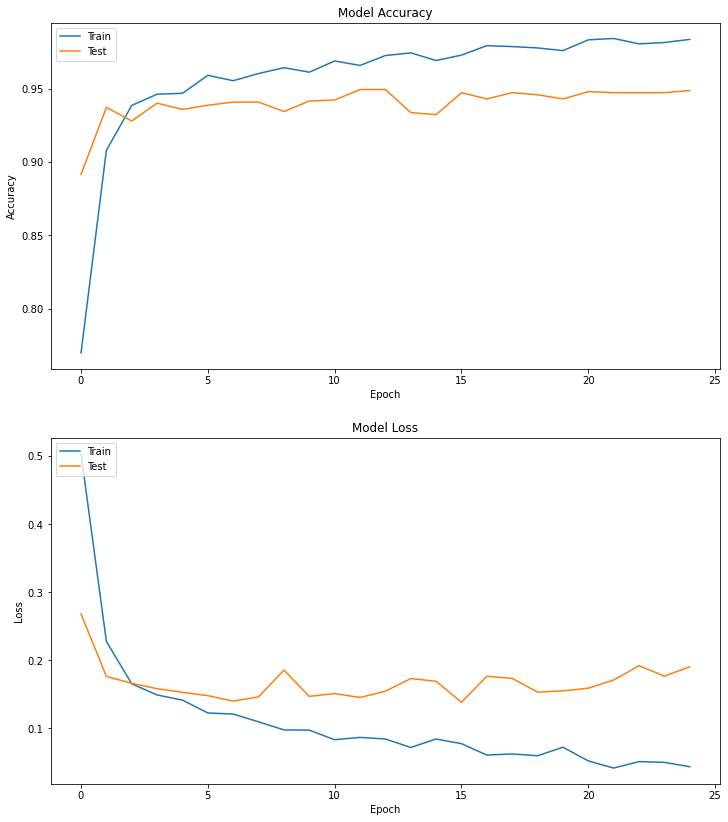

In [59]:
plot_accuracy_loss()

In [60]:
y_pred=cnn_1.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

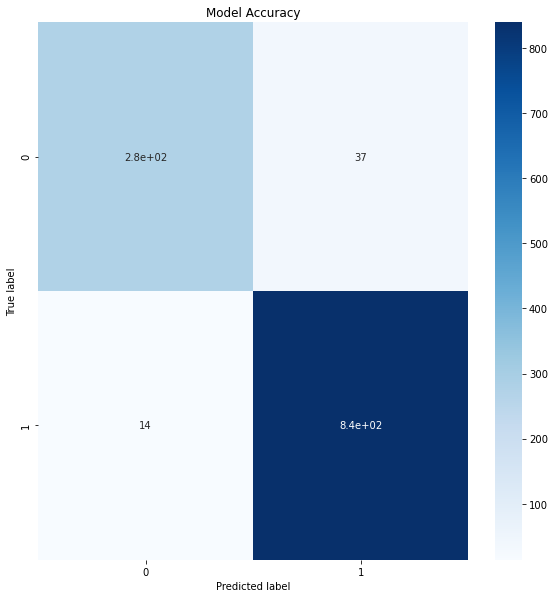

In [61]:
plot_confusion(con_mat)

In [62]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.88      0.92       315
           1       0.96      0.98      0.97       853

    accuracy                           0.96      1168
   macro avg       0.95      0.93      0.94      1168
weighted avg       0.96      0.96      0.96      1168



<Figure size 864x1008 with 0 Axes>

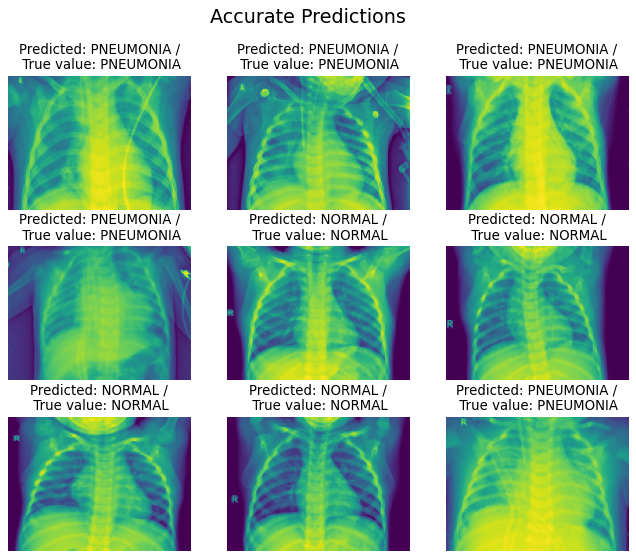

In [63]:
plot_model_images_acc()

<Figure size 864x1008 with 0 Axes>

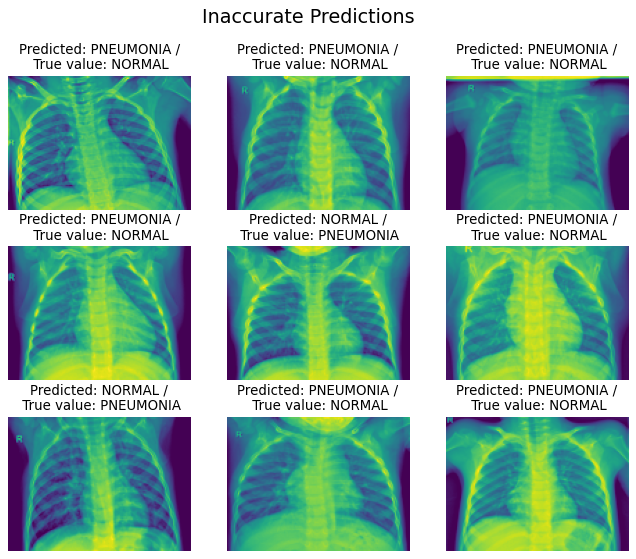

In [64]:
plot_model_images_inc()

In [65]:
cnn_1_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_1_pre_score = precision_score(y_test, y_pred_rounded)
cnn_1_rec_score = recall_score(y_test, y_pred_rounded)
cnn_1_f1_score = f1_score(y_test, y_pred_rounded)

#### Better results, but lets try another model.

### 6b. Convolutional Neural Network 2

In [66]:
def base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(im_height, im_width, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_2 = base_model()
cnn_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 97, 132, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 66, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 66, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 33, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 33, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 33, 64)       

In [67]:
## Training model

es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_2.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/25
103/103 [==============================] - 56s 541ms/step - loss: 0.5191 - accuracy: 0.7593 - val_loss: 0.5170 - val_accuracy: 0.7218
Epoch 2/25
103/103 [==============================] - 56s 546ms/step - loss: 0.2604 - accuracy: 0.8988 - val_loss: 0.2966 - val_accuracy: 0.8730
Epoch 3/25
103/103 [==============================] - 55s 535ms/step - loss: 0.2170 - accuracy: 0.9095 - val_loss: 0.2084 - val_accuracy: 0.9137
Epoch 4/25
103/103 [==============================] - 56s 542ms/step - loss: 0.1875 - accuracy: 0.9312 - val_loss: 0.1899 - val_accuracy: 0.9344
Epoch 5/25
103/103 [==============================] - 56s 541ms/step - loss: 0.1540 - accuracy: 0.9419 - val_loss: 0.2536 - val_accuracy: 0.8966
Epoch 6/25
103/103 [==============================] - 56s 543ms/step - loss: 0.1625 - accuracy: 0.9398 - val_loss: 0.1804 - val_accuracy: 0.9322
Epoch 7/25
103/103 [==============================] - 55s 535ms/step - loss: 0.1353 - accuracy: 0.9489 - val_loss: 0.1427 - val_ac

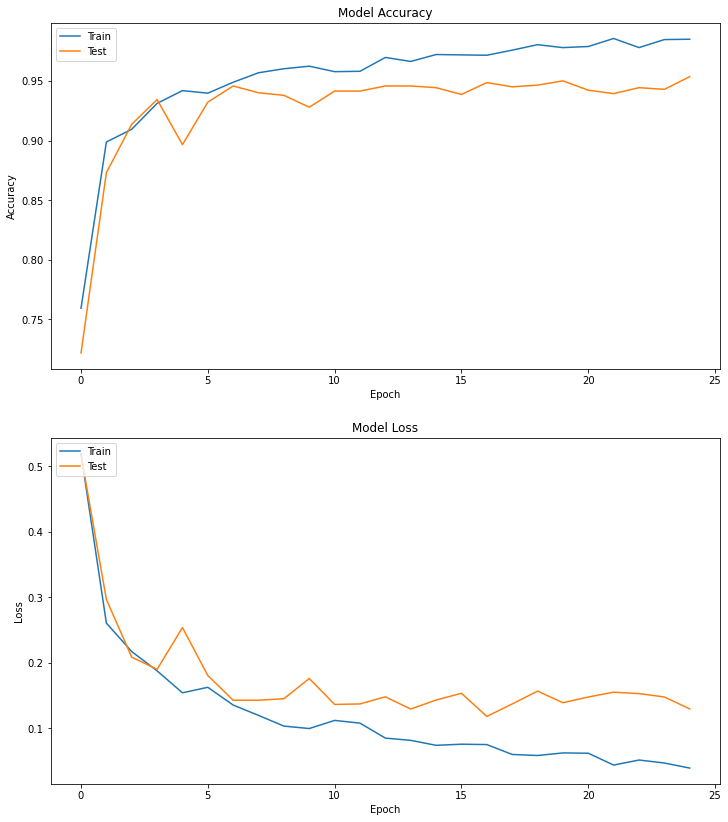

In [68]:
plot_accuracy_loss()

In [69]:
y_pred=cnn_2.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

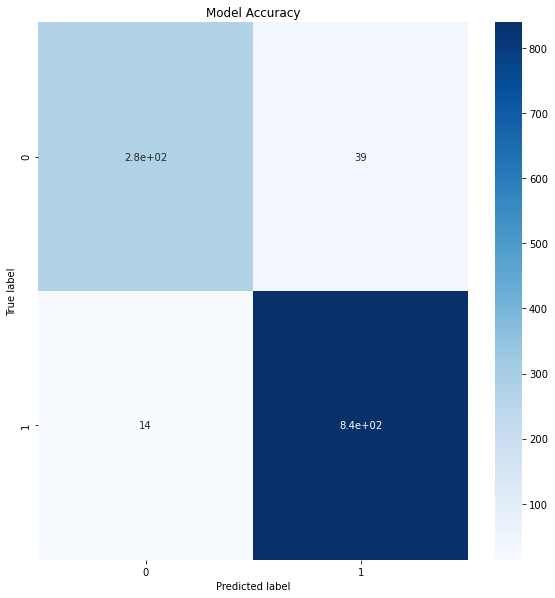

In [70]:
plot_confusion(con_mat)

In [71]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       315
           1       0.96      0.98      0.97       853

    accuracy                           0.95      1168
   macro avg       0.95      0.93      0.94      1168
weighted avg       0.95      0.95      0.95      1168



<Figure size 864x1008 with 0 Axes>

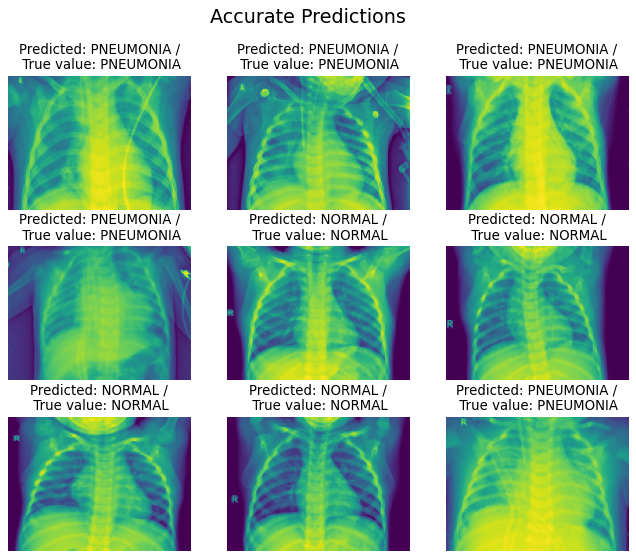

In [72]:
plot_model_images_acc()

<Figure size 864x1008 with 0 Axes>

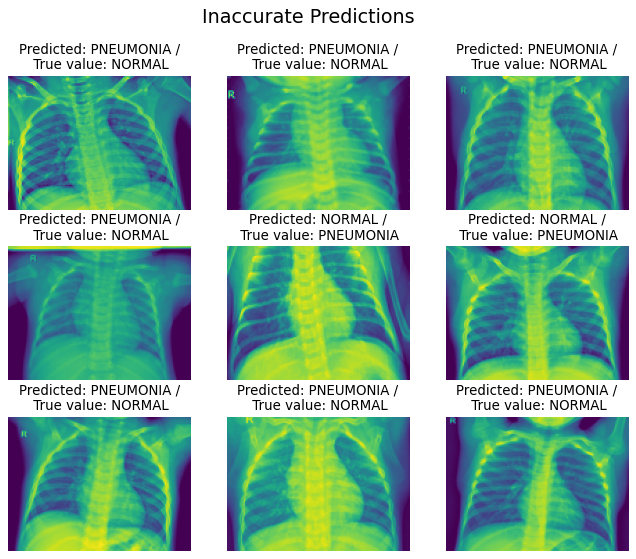

In [73]:
plot_model_images_inc()

In [74]:
cnn_2_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_2_pre_score = precision_score(y_test, y_pred_rounded)
cnn_2_rec_score = recall_score(y_test, y_pred_rounded)
cnn_2_f1_score = f1_score(y_test, y_pred_rounded)

#### There was not much of a change, so now lets try hyperparameter tuning a model.

### 6c. Hyperparameter Tuned Convolutional Neural Network

In [75]:
class CNNHyperModel(HyperModel):
  #def __init__(self, input_shape, num_classes):
    #self.input_shape =input_shape
    #self.num_classes =num_classes

    def build(self,hp):
        model=Sequential()
        model.add(Conv2D(filters=hp.Int('1Conv_num_classes',default=32,min_value=32,step=16,
                                        max_value=256),
                      activation="relu",padding='same', kernel_size=(3,3),input_shape=(im_height, im_width, 1)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("2Conv_num_classes",default=32,min_value=32,
                                      max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("1Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Conv2D(filters=hp.Int("3Conv_num_classes",default=64,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("4Conv_num_classes",default=64,min_value=32,
                            max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("2Dropout", min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Conv2D(filters=hp.Int("5Conv_num_classes",default=128,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(filters=hp.Int("6Conv_NUM_CLASSES",default=128,min_value=32,
                                       max_value=256,step=16),
                     activation='relu',padding='same',kernel_size=(3,3)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(rate=hp.Float("3Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Flatten())
        model.add(Dense(units=hp.Int("Dense",min_value=32,default=516,
                                 max_value=512,step=16),activation='relu'))
        model.add(Dropout(rate=hp.Float("Dense_Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Dense(units=hp.Int("2Dense",min_value=32,default=516,
                                 max_value=512,step=16),activation='relu'))
        model.add(Dropout(rate=hp.Float("2Dense_Dropout",min_value=0.0,
                                    max_value=0.5,step=0.05)))
        model.add(Dense(1,activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        return model
    
hypermodel=CNNHyperModel()

In [76]:
## Creating a tuner for my model. 

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Pneumonia Classification')

INFO:tensorflow:Reloading Oracle from existing project project/Pneumonia Classification/oracle.json
INFO:tensorflow:Reloading Tuner from project/Pneumonia Classification/tuner0.json


In [77]:
tuner.search_space_summary()

Search space summary
Default search space size: 13
1Conv_num_classes (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
2Conv_num_classes (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
1Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
3Conv_num_classes (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
4Conv_num_classes (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
2Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
5Conv_num_classes (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': None}
6Conv_NUM_CLASSES (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256,

In [78]:
## Hyperparameter tuning to find the best model

tuner.search(X_train, y_train,
             epochs=epochs,
             validation_data=(X_test, y_test),
            validation_split=0.3)

Trial 6 Complete [04h 29m 59s]
val_accuracy: 0.9541131655375162

Best val_accuracy So Far: 0.9595815340677897
Total elapsed time: 10h 30m 14s
INFO:tensorflow:Oracle triggered exit


In [79]:
best_model = tuner.get_best_models()[0]

In [93]:
## Training Best model

es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/25
103/103 [==============================] - 92s 896ms/step - loss: 0.0460 - accuracy: 0.9841 - val_loss: 0.0984 - val_accuracy: 0.9636
Epoch 2/25
103/103 [==============================] - 100s 967ms/step - loss: 0.0778 - accuracy: 0.9679 - val_loss: 0.1083 - val_accuracy: 0.9586
Epoch 3/25
103/103 [==============================] - 95s 922ms/step - loss: 0.0573 - accuracy: 0.9777 - val_loss: 0.0966 - val_accuracy: 0.9650
Epoch 4/25
103/103 [==============================] - 94s 909ms/step - loss: 0.0381 - accuracy: 0.9832 - val_loss: 0.1130 - val_accuracy: 0.9558
Epoch 5/25
103/103 [==============================] - 92s 890ms/step - loss: 0.0394 - accuracy: 0.9856 - val_loss: 0.1445 - val_accuracy: 0.9565
Epoch 6/25
103/103 [==============================] - 91s 887ms/step - loss: 0.0507 - accuracy: 0.9810 - val_loss: 0.1174 - val_accuracy: 0.9593
Epoch 7/25
103/103 [==============================] - 90s 871ms/step - loss: 0.0620 - accuracy: 0.9780 - val_loss: 0.0984 - val_a

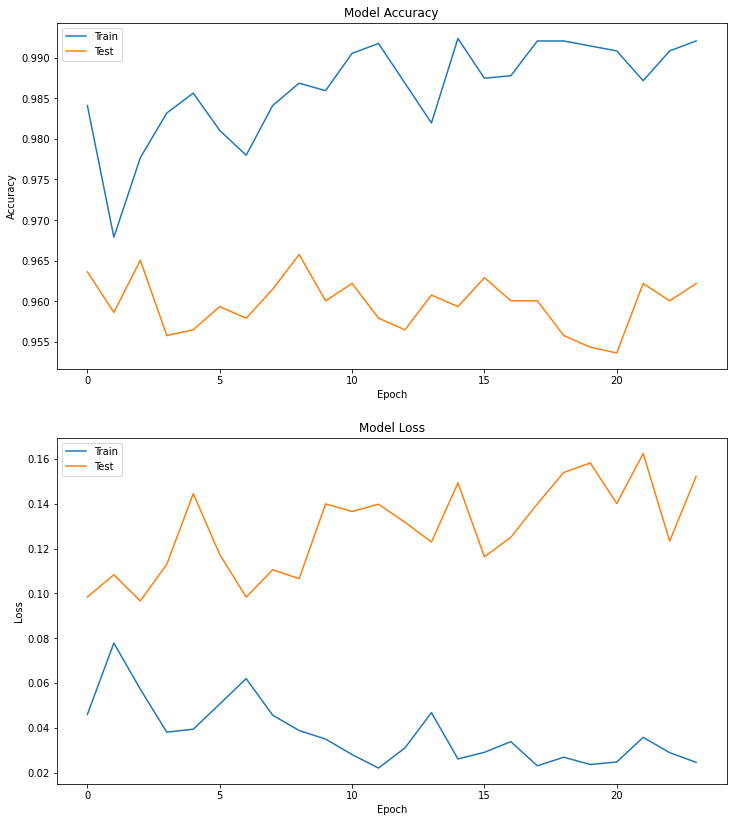

In [94]:
plot_accuracy_loss()

In [95]:
y_pred=best_model.predict(X_test)
y_pred_rounded = np.round(y_pred)
con_mat = confusion_matrix(y_test, y_pred_rounded)

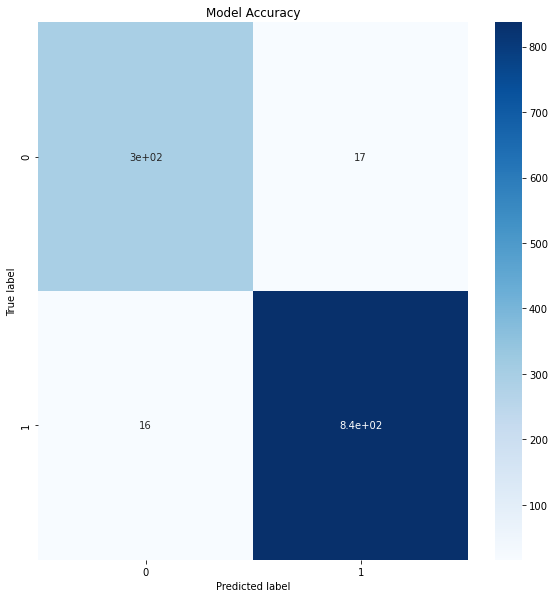

In [96]:
plot_confusion(con_mat)

In [97]:
print('Classification report: \n', classification_report(y_test, y_pred_rounded))

Classification report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       315
           1       0.98      0.98      0.98       853

    accuracy                           0.97      1168
   macro avg       0.96      0.96      0.96      1168
weighted avg       0.97      0.97      0.97      1168



<Figure size 864x1008 with 0 Axes>

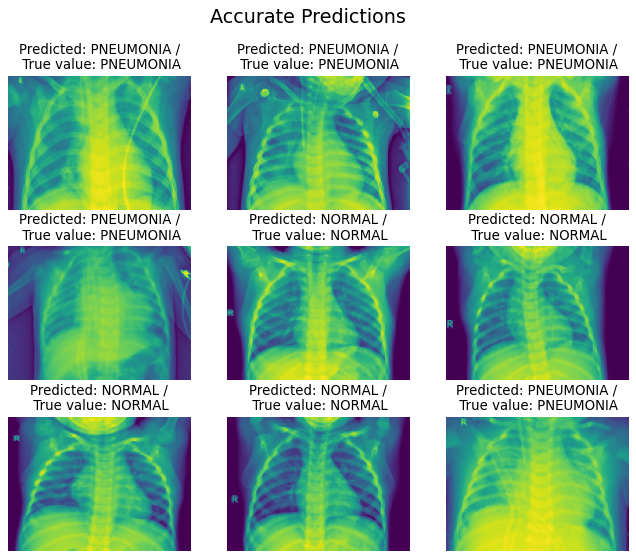

In [98]:
plot_model_images_acc()

<Figure size 864x1008 with 0 Axes>

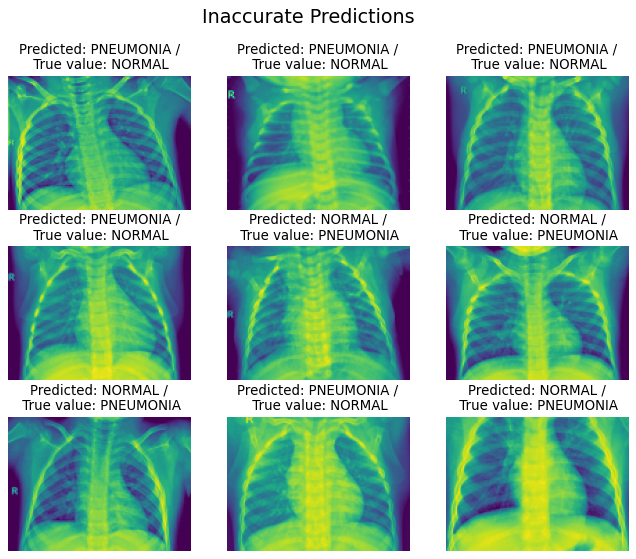

In [99]:
plot_model_images_inc()

In [100]:
cnn_hyp_acc_score = accuracy_score(y_test, y_pred_rounded)
cnn_hyp_pre_score = precision_score(y_test, y_pred_rounded)
cnn_hyp_rec_score = recall_score(y_test, y_pred_rounded)
cnn_hyp_f1_score = f1_score(y_test, y_pred_rounded)

### 7. Model Selection

In [101]:
# Creating a models table
model_selection=pd.DataFrame({'Model':['Logistic Regession', 'Decision Tree Classifier', 'Random Forest Classifier',
                                        'XGBClassifier', 'Convolutional Neural Network 1',
                                      'Convolutional Neural Network 2', 'Hyperparameter Tuned Convolutional Neural Network'], 
                             'Accuracy Score':[lg_acc_score, dt_acc_score, rf_acc_score, xgb_acc_score, cnn_1_acc_score, cnn_2_acc_score, cnn_hyp_acc_score],
                             'Precision Score':[lg_pre_score, dt_pre_score, rf_pre_score, xgb_pre_score, cnn_1_pre_score, cnn_2_pre_score, cnn_hyp_pre_score],
                             'Recall Score':[lg_rec_score, dt_rec_score, rf_rec_score, xgb_rec_score, cnn_1_rec_score, cnn_2_rec_score, cnn_hyp_rec_score],
                             'F1 Score':[lg_f1_score, dt_f1_score, rf_f1_score, xgb_f1_score, cnn_1_f1_score, cnn_2_f1_score, cnn_hyp_f1_score]})

In [102]:
model_selection

Model  Accuracy Score  \
0                                 Logistic Regession        0.893836   
1                           Decision Tree Classifier        0.720890   
2                           Random Forest Classifier        0.730308   
3                                      XGBClassifier        0.881849   
4                     Convolutional Neural Network 1        0.956336   
5                     Convolutional Neural Network 2        0.954623   
6  Hyperparameter Tuned Convolutional Neural Network        0.971747   

   Precision Score  Recall Score  F1 Score  
0         0.969112      0.882767  0.923926  
1         0.730131      0.980070  0.836837  
2         0.730308      1.000000  0.844137  
3         0.867420      0.989449  0.924425  
4         0.957763      0.983587  0.970503  
5         0.955581      0.983587  0.969382  
6         0.980094      0.981243  0.980668

#### The final Hyperparameter tuned Convolutional Neural Network is by far the best results. It out scored all other models in three of the four scores recorded, and was one of the top scoring in recall as well. 